In [1]:
from __future__ import division, print_function, absolute_import
from scipy.io import loadmat 
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib.backends.backend_pdf import PdfPages
from hyperdash import monitor_cell
from hyperdash import Experiment

In [2]:
import sys
def printf(format, *args):
    sys.stdout.write(format % args)

In [3]:
def data_split (tdata):
    #tdata = tdata.transpose()
    td1, td2, td3, td4, td5, td6, td7, td8, td9, td10 = np.array_split(tdata, 10)
    
    tdata = np.concatenate((td1, td2, td3, td4, td5, td6, td7, td8), axis = 0)
    test_data = np.concatenate((td9, td10), axis = 0)
    
    #tdata = tdata.transpose()
    #test_data = test_data.transpose()
    
    
    return tdata, test_data

In [4]:
def data_loader(trainDir):
    ###############################################################################
    # This section loads the training dataset
    ###############################################################################
    trainDir            = trainDir
    TrainingDataFiles   = []

    for r, d, f in os.walk(trainDir):
        for file in f:
            TrainingDataFiles.append(os.path.join(r,file))

    # load files and put them into a matrix
    tdata = loadmat(TrainingDataFiles[0])['X']          
    for i in range(1,len(TrainingDataFiles)):            
        td      = loadmat(TrainingDataFiles[i])['X']
        tdata   = np.concatenate((tdata,td), axis = 1)

    # put observations in rows
    tdata       = tdata.transpose()
    print(tdata.shape)
    ###############################################################################
    # Splits Data into training (80%) and testing (20%)
    ###############################################################################
    #tdata, test_data = data_split(tdata)
    return tdata

In [5]:
def sparseLinAutoEncoder(wscale, learn_rate, num_steps, beta, counter, tdata):   
    # simulation meta-parameters
    wscale          = wscale;  # scale of the small random weights for model initialization
    beta            = beta;  # hyper-parameter which determines penality size
    learn_rate      = learn_rate;
    batch_size      = 5000;
    nBat            = 50000;
    num_steps       = num_steps;
    display_step    = 100
    examples_to_show    = 5

  
    exp = Experiment("SparceLinAutoEncoderRELU8")
    
    ###############################################################################
    # Splits Data into training (80%) and testing (20%)
    ###############################################################################
    tdata, test_data = data_split(tdata)
    
    
    ###############################################################################
    # Define neural network graph
    ###############################################################################
    num_input   = tdata.shape[1]
    num_train   = tdata.shape[0]
    pixel_size  = int(np.sqrt(float(num_input)))

    # compressive auto-encoder reduces dimensionality
    # num_hidden  = round(num_input/2)
    # sparse auto-encoder keeps dimensionality same or larger
    num_hidden = num_input 

    # this placeholder will hold the training batch
    X = tf.placeholder("float", [None, num_input])


    ## These are a hash map to variables that are used as the weights and biases in 
    ## the neural network layers. Note that the layers have differnet number of filters
    ## and that the input passes through these layers and take the shape of the layers.
    ## It helps to think of a network as a pipline.
    weights = {
        'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden],mean=0.0, stddev=wscale)),
        'decoder_h1': tf.Variable(tf.random_normal([num_hidden, num_input],mean=0.0, stddev=wscale))
    }

    ## Building the encoder This layer has two layers that are concatinated into a 
    ## a single layer. This layer should reduce the input vector to a matrix of diffrent
    ## deminsions.
    def encoder(x):
        # Encoder Hidden layer with sigmoid activation #1
        layer_1 = tf.nn.relu(tf.matmul(x, weights['encoder_h1']))
        return layer_1

    ## Building the decoder This is simular to the process that is happening in the
    ## encoder code but this layer further reduces the demensionality.
    def decoder(x):
        # Decoder Hidden layer with sigmoid activation #1
        layer_1 = tf.matmul(x, weights['decoder_h1'])
        #layer_1 =  tf.matmul(x, tf.transpose(weights['encoder_h1']))
        return layer_1

    ## Construct model by forming the encoded input and the decoded encoder
    encoder_op = encoder(X)
    decoder_op = decoder(encoder_op)

    ## Prediction 
    y_pred = decoder_op
    # Targets (Labels) are the input data.
    y_true = X

    ## Define loss and optimizer, minimize the squared error


    errorterm   = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
    sparseterm  = tf.reduce_mean(tf.abs(encoder_op))

    loss        = errorterm + beta*sparseterm 

    ## Note this is not the only optimizer and infact we should look into which one we
    ## should use for our project!!!!! ADAMOptimizer is a well known and utilize option. 
    optimizer = tf.train.AdamOptimizer(learn_rate).minimize(loss)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    #
    ## Initialize the variables (i.e. assign their default value)
    init    = tf.global_variables_initializer()
    saver   = tf.train.Saver()

    ###############################################################################
    # Start Training
    ###############################################################################

    # Start a new TF session
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)

        # Training
        for i in range(1, num_steps+1):
            # Prepare Data
            temp    = np.random.permutation(num_train)
            bat_ind = temp[0:batch_size]
            batch_x = tdata[bat_ind,:]


            # Run optimization op (backprop) and cost op (to get loss value)
            _, l , e, s = sess.run([optimizer, loss, errorterm, sparseterm], feed_dict={X: batch_x})
            # Display logs per step
            if i % display_step == 0 or i == 1:
                print('Step %i: Minibatch Loss: %f Error: %f Sparse: %f' % (i, l, e, s))
                exp.metric("Loss ", e);
                exp.metric("Sparse ", s);

        final_W = weights['encoder_h1'].eval()

        # Testing
        # Encode and decode images from test set and visualize their reconstruction.
        n = examples_to_show
        k1 = 1
        k2 = 1
        canvas_orig = np.empty((pixel_size * n, pixel_size * n))
        canvas_recon = np.empty((pixel_size * n, pixel_size * n))
        for i in range(n):

            g = sess.run(decoder_op, feed_dict={X: batch_x})
            # Display original images
            for j in range(n):
                # Draw the original digits
                canvas_orig[i * pixel_size:(i + 1) * pixel_size, j * pixel_size:(j + 1) * pixel_size] = \
                    batch_x[k1].reshape([pixel_size, pixel_size])
                k1 = k1 + 1
            # Display reconstructed images
            for j in range(n):
                # Draw the reconstructed digits
                canvas_recon[i * pixel_size:(i + 1) * pixel_size, j * pixel_size:(j + 1) * pixel_size] = \
                    g[k2].reshape([pixel_size, pixel_size])
                k2 = k2 + 1

        #print("Original Images")
        #plt.figure(figsize=(n, n))
        #plt.imshow(canvas_orig, origin="upper", cmap="gray")
        #plt.show()

        #print("Reconstructed Images")
        #plt.figure(figsize=(n, n))
        #plt.imshow(canvas_recon, origin="upper", cmap="gray")
        #plt.show()
        #print(canvas_orig)
        
        
        save_path = saver.save(sess,"./epochCkpt/sparseLinTrainMiniBatFinal" + str(counter) + ".ckpt")
        

    
    Z = final_W
    nHid            = Z.shape[1]            # get the number of hidden units
    imSz            = int(np.sqrt(Z.shape[0]))   # size of each image patch
    plotGap2        = 1                     # half the gap to leave between each image patch
    imSzPlot        = int(imSz + 2*plotGap2)    

    layoutSqDim     = int(np.ceil(np.sqrt(nHid)))  # find dimensions for layout
    arrayImage      = np.zeros((layoutSqDim*imSzPlot,layoutSqDim*imSzPlot))

    k = 0
    for i in range(layoutSqDim):
        for j in range(layoutSqDim):
            if k < nHid:    
                littleImPlot = np.zeros((imSzPlot,imSzPlot))
                littleImPlot[(plotGap2):(imSzPlot-plotGap2),(plotGap2):(imSzPlot-plotGap2)] = np.reshape(Z[:,k],(imSz,imSz)) 
                arrayImage[ (i*imSzPlot ):((i+1)*imSzPlot) , (j*imSzPlot ):((j+1)*imSzPlot) ] = littleImPlot;
                k = k + 1

    output = [l, e, s, canvas_orig, canvas_recon, arrayImage]
    plt.imshow(arrayImage,  cmap='Greys')
    #plt.show()
    
    sess.close()
    exp.end()
    return output
    

(80000, 64)
Step 1: Minibatch Loss: 0.020222 Error: 0.018280 Sparse: 0.038852
| Loss :   0.018280 |
| Sparse :   0.038852 |
Step 100: Minibatch Loss: 0.003420 Error: 0.002434 Sparse: 0.019704
| Loss :   0.002434 |
| Sparse :   0.019704 |
Step 200: Minibatch Loss: 0.003720 Error: 0.002890 Sparse: 0.016605
| Loss :   0.002890 |
| Sparse :   0.016605 |
Step 300: Minibatch Loss: 0.003156 Error: 0.002394 Sparse: 0.015246
| Loss :   0.002394 |
| Sparse :   0.015246 |
Step 400: Minibatch Loss: 0.002785 Error: 0.002101 Sparse: 0.013679
| Loss :   0.002101 |
| Sparse :   0.013679 |
Step 500: Minibatch Loss: 0.002717 Error: 0.002055 Sparse: 0.013244
| Loss :   0.002055 |
| Sparse :   0.013244 |
Step 600: Minibatch Loss: 0.002706 Error: 0.002038 Sparse: 0.013365
| Loss :   0.002038 |
| Sparse :   0.013365 |
Step 700: Minibatch Loss: 0.002893 Error: 0.002238 Sparse: 0.013114
| Loss :   0.002238 |
| Sparse :   0.013114 |
Step 800: Minibatch Loss: 0.002838 Error: 0.002220 Sparse: 0.012368
| Loss :  

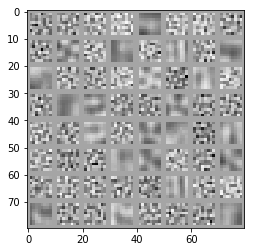

In [6]:
tdata = data_loader('RawData/TrainingData8')
out = sparseLinAutoEncoder(.1, .05, 1000, .05 ,555, tdata)

In [ ]:
%%monitor_cell "Metric Eval"
counter = 0
tdata = data_loader('RawData/TrainingData8')
with PdfPages('Results/ModelPlotsRELU8_2.pdf') as pdf:
    for wscale in range(-3,-1,1):
        wscale = 1*(10**wscale)
        for learn_rate in range(-4,1,1):
            learn_rate = 5*(10**learn_rate)
            for nIterBat in range(1000,6000,1000):
                for beta in range(-4,1,1):
                    
                    beta = 1*(10**beta)
                    counter = counter + 1
                    out = sparseLinAutoEncoder(wscale, learn_rate, nIterBat, beta, counter, tdata)
                    fig = plt.figure(figsize=(15, 7))
                    txt = "Trained model : %d \n _________________________\n wscale : %f \n learn_rate : %f \n batch size : %d \n beta : %f \n loss : %f \n msq : %f  \n sparsity : %f \n" %(counter, wscale,learn_rate, nIterBat, beta, out[0], out[1], out[2])
                    fig.suptitle(txt,x = 0.1, y= .65, fontsize=14, fontweight='bold', ha = 'left')
                    
                    fig.add_subplot(1,4,1).axis('off')

                    fig.add_subplot(1, 4 , 2)
                    plt.title('Original Images')
                    plt.imshow(out[3], origin="upper", cmap="gray")
                    fig.add_subplot(1,4,3)
                    plt.title('Reconstructed Images')
                    plt.imshow(out[4], origin="upper", cmap="gray")
                    fig.add_subplot(1,4,4)
                    plt.title('Wight Plots')
                    plt.imshow(out[5], cmap="gray")
                    pdf.savefig(fig)

(80000, 64)
Step 1: Minibatch Loss: 0.015425 Error: 0.015425 Sparse: 0.000392
| Loss :   0.015425 |
| Sparse :   0.000392 |
Step 100: Minibatch Loss: 0.009915 Error: 0.009911 Sparse: 0.040146
| Loss :   0.009911 |
| Sparse :   0.040146 |
Step 200: Minibatch Loss: 0.006877 Error: 0.006872 Sparse: 0.050970
| Loss :   0.006872 |
| Sparse :   0.050970 |
Step 300: Minibatch Loss: 0.005377 Error: 0.005371 Sparse: 0.055521
| Loss :   0.005371 |
| Sparse :   0.055521 |
Step 400: Minibatch Loss: 0.004381 Error: 0.004376 Sparse: 0.058512
| Loss :   0.004376 |
| Sparse :   0.058512 |
Step 500: Minibatch Loss: 0.003721 Error: 0.003715 Sparse: 0.059905
| Loss :   0.003715 |
| Sparse :   0.059905 |
Step 600: Minibatch Loss: 0.003212 Error: 0.003206 Sparse: 0.061392
| Loss :   0.003206 |
| Sparse :   0.061392 |
Step 700: Minibatch Loss: 0.002870 Error: 0.002863 Sparse: 0.061906
| Loss :   0.002863 |
| Sparse :   0.061906 |
Step 800: Minibatch Loss: 0.002644 Error: 0.002638 Sparse: 0.062645
| Loss :  

| Sparse :   0.062767 |
Step 800: Minibatch Loss: 0.002664 Error: 0.002658 Sparse: 0.063072
| Loss :   0.002658 |
| Sparse :   0.063072 |
Step 900: Minibatch Loss: 0.002466 Error: 0.002460 Sparse: 0.063292
| Loss :   0.002460 |
| Sparse :   0.063292 |
Step 1000: Minibatch Loss: 0.002405 Error: 0.002399 Sparse: 0.063112
| Loss :   0.002399 |
| Sparse :   0.063112 |
Step 1100: Minibatch Loss: 0.002300 Error: 0.002294 Sparse: 0.062368
| Loss :   0.002294 |
| Sparse :   0.062368 |
Step 1200: Minibatch Loss: 0.002271 Error: 0.002264 Sparse: 0.061706
| Loss :   0.002264 |
| Sparse :   0.061706 |
Step 1300: Minibatch Loss: 0.002180 Error: 0.002174 Sparse: 0.061347
| Loss :   0.002174 |
| Sparse :   0.061347 |
Step 1400: Minibatch Loss: 0.002131 Error: 0.002125 Sparse: 0.060947
| Loss :   0.002125 |
| Sparse :   0.060947 |
Step 1500: Minibatch Loss: 0.002103 Error: 0.002097 Sparse: 0.060730
| Loss :   0.002097 |
| Sparse :   0.060730 |
Step 1600: Minibatch Loss: 0.002099 Error: 0.002093 Sparse

Step 1100: Minibatch Loss: 0.007129 Error: 0.005883 Sparse: 0.012464
| Loss :   0.005883 |
| Sparse :   0.012464 |
Step 1200: Minibatch Loss: 0.006913 Error: 0.005629 Sparse: 0.012841
| Loss :   0.005629 |
| Sparse :   0.012841 |
Step 1300: Minibatch Loss: 0.006410 Error: 0.005079 Sparse: 0.013309
| Loss :   0.005079 |
| Sparse :   0.013309 |
Step 1400: Minibatch Loss: 0.006000 Error: 0.004643 Sparse: 0.013573
| Loss :   0.004643 |
| Sparse :   0.013573 |
Step 1500: Minibatch Loss: 0.005783 Error: 0.004448 Sparse: 0.013349
| Loss :   0.004448 |
| Sparse :   0.013349 |
Step 1600: Minibatch Loss: 0.005601 Error: 0.004270 Sparse: 0.013303
| Loss :   0.004270 |
| Sparse :   0.013303 |
Step 1700: Minibatch Loss: 0.005210 Error: 0.003854 Sparse: 0.013560
| Loss :   0.003854 |
| Sparse :   0.013560 |
Step 1800: Minibatch Loss: 0.005078 Error: 0.003738 Sparse: 0.013409
| Loss :   0.003738 |
| Sparse :   0.013409 |
Step 1900: Minibatch Loss: 0.004752 Error: 0.003388 Sparse: 0.013647
| Loss :   

Step 400: Minibatch Loss: 0.004493 Error: 0.004435 Sparse: 0.057600
| Loss :   0.004435 |
| Sparse :   0.057600 |
Step 500: Minibatch Loss: 0.003810 Error: 0.003751 Sparse: 0.059413
| Loss :   0.003751 |
| Sparse :   0.059413 |
Step 600: Minibatch Loss: 0.003341 Error: 0.003281 Sparse: 0.060120
| Loss :   0.003281 |
| Sparse :   0.060120 |
Step 700: Minibatch Loss: 0.003021 Error: 0.002960 Sparse: 0.060954
| Loss :   0.002960 |
| Sparse :   0.060954 |
Step 800: Minibatch Loss: 0.002762 Error: 0.002701 Sparse: 0.061085
| Loss :   0.002701 |
| Sparse :   0.061085 |
Step 900: Minibatch Loss: 0.002609 Error: 0.002548 Sparse: 0.060927
| Loss :   0.002548 |
| Sparse :   0.060927 |
Step 1000: Minibatch Loss: 0.002519 Error: 0.002458 Sparse: 0.060504
| Loss :   0.002458 |
| Sparse :   0.060504 |
Step 1100: Minibatch Loss: 0.002410 Error: 0.002350 Sparse: 0.059647
| Loss :   0.002350 |
| Sparse :   0.059647 |
Step 1200: Minibatch Loss: 0.002292 Error: 0.002233 Sparse: 0.059304
| Loss :   0.0022

Step 1000: Minibatch Loss: 0.007217 Error: 0.005911 Sparse: 0.013066
| Loss :   0.005911 |
| Sparse :   0.013066 |
Step 1100: Minibatch Loss: 0.006820 Error: 0.005453 Sparse: 0.013670
| Loss :   0.005453 |
| Sparse :   0.013670 |
Step 1200: Minibatch Loss: 0.006368 Error: 0.004957 Sparse: 0.014107
| Loss :   0.004957 |
| Sparse :   0.014107 |
Step 1300: Minibatch Loss: 0.006073 Error: 0.004676 Sparse: 0.013973
| Loss :   0.004676 |
| Sparse :   0.013973 |
Step 1400: Minibatch Loss: 0.005860 Error: 0.004498 Sparse: 0.013619
| Loss :   0.004498 |
| Sparse :   0.013619 |
Step 1500: Minibatch Loss: 0.005706 Error: 0.004369 Sparse: 0.013363
| Loss :   0.004369 |
| Sparse :   0.013363 |
Step 1600: Minibatch Loss: 0.005468 Error: 0.004134 Sparse: 0.013336
| Loss :   0.004134 |
| Sparse :   0.013336 |
Step 1700: Minibatch Loss: 0.005250 Error: 0.003909 Sparse: 0.013408
| Loss :   0.003909 |
| Sparse :   0.013408 |
Step 1800: Minibatch Loss: 0.004996 Error: 0.003661 Sparse: 0.013352
| Loss :   

| Sparse :   0.060352 |
Step 1600: Minibatch Loss: 0.002077 Error: 0.002071 Sparse: 0.059956
| Loss :   0.002071 |
| Sparse :   0.059956 |
Step 1700: Minibatch Loss: 0.002060 Error: 0.002054 Sparse: 0.059876
| Loss :   0.002054 |
| Sparse :   0.059876 |
Step 1800: Minibatch Loss: 0.002049 Error: 0.002043 Sparse: 0.059693
| Loss :   0.002043 |
| Sparse :   0.059693 |
Step 1900: Minibatch Loss: 0.002016 Error: 0.002010 Sparse: 0.059817
| Loss :   0.002010 |
| Sparse :   0.059817 |
Step 2000: Minibatch Loss: 0.001991 Error: 0.001985 Sparse: 0.059810
| Loss :   0.001985 |
| Sparse :   0.059810 |
Step 2100: Minibatch Loss: 0.001974 Error: 0.001968 Sparse: 0.059828
| Loss :   0.001968 |
| Sparse :   0.059828 |
Step 2200: Minibatch Loss: 0.001963 Error: 0.001957 Sparse: 0.059698
| Loss :   0.001957 |
| Sparse :   0.059698 |
Step 2300: Minibatch Loss: 0.001966 Error: 0.001960 Sparse: 0.059601
| Loss :   0.001960 |
| Sparse :   0.059601 |
Step 2400: Minibatch Loss: 0.001928 Error: 0.001922 Spar

| Sparse :   0.035272 |
Step 200: Minibatch Loss: 0.007339 Error: 0.006887 Sparse: 0.045261
| Loss :   0.006887 |
| Sparse :   0.045261 |
Step 300: Minibatch Loss: 0.005871 Error: 0.005392 Sparse: 0.047907
| Loss :   0.005392 |
| Sparse :   0.047907 |
Step 400: Minibatch Loss: 0.005000 Error: 0.004505 Sparse: 0.049446
| Loss :   0.004505 |
| Sparse :   0.049446 |
Step 500: Minibatch Loss: 0.004195 Error: 0.003696 Sparse: 0.049901
| Loss :   0.003696 |
| Sparse :   0.049901 |
Step 600: Minibatch Loss: 0.003681 Error: 0.003181 Sparse: 0.050074
| Loss :   0.003181 |
| Sparse :   0.050074 |
Step 700: Minibatch Loss: 0.003318 Error: 0.002819 Sparse: 0.049866
| Loss :   0.002819 |
| Sparse :   0.049866 |
Step 800: Minibatch Loss: 0.003110 Error: 0.002619 Sparse: 0.049159
| Loss :   0.002619 |
| Sparse :   0.049159 |
Step 900: Minibatch Loss: 0.002992 Error: 0.002509 Sparse: 0.048350
| Loss :   0.002509 |
| Sparse :   0.048350 |
Step 1000: Minibatch Loss: 0.002808 Error: 0.002337 Sparse: 0.04

| Sparse :   0.012435 |
Step 3100: Minibatch Loss: 0.003224 Error: 0.002006 Sparse: 0.012178
| Loss :   0.002006 |
| Sparse :   0.012178 |
Step 3200: Minibatch Loss: 0.003187 Error: 0.002001 Sparse: 0.011856
| Loss :   0.002001 |
| Sparse :   0.011856 |
Step 3300: Minibatch Loss: 0.003220 Error: 0.002053 Sparse: 0.011671
| Loss :   0.002053 |
| Sparse :   0.011671 |
Step 3400: Minibatch Loss: 0.003116 Error: 0.001980 Sparse: 0.011361
| Loss :   0.001980 |
| Sparse :   0.011361 |
Step 3500: Minibatch Loss: 0.003127 Error: 0.002015 Sparse: 0.011119
| Loss :   0.002015 |
| Sparse :   0.011119 |
Step 3600: Minibatch Loss: 0.003076 Error: 0.001980 Sparse: 0.010955
| Loss :   0.001980 |
| Sparse :   0.010955 |
Step 3700: Minibatch Loss: 0.003050 Error: 0.001978 Sparse: 0.010719
| Loss :   0.001978 |
| Sparse :   0.010719 |
Step 3800: Minibatch Loss: 0.003026 Error: 0.001974 Sparse: 0.010513
| Loss :   0.001974 |
| Sparse :   0.010513 |
Step 3900: Minibatch Loss: 0.002976 Error: 0.001949 Spar

C:\Users\cjhamilton4176\AppData\Local\conda\conda\envs\DeepLearner\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Step 1: Minibatch Loss: 0.015459 Error: 0.015459 Sparse: 0.000408
| Loss :   0.015459 |
| Sparse :   0.000408 |
Step 100: Minibatch Loss: 0.010079 Error: 0.010075 Sparse: 0.039604
| Loss :   0.010075 |
| Sparse :   0.039604 |
Step 200: Minibatch Loss: 0.006744 Error: 0.006739 Sparse: 0.050961
| Loss :   0.006739 |
| Sparse :   0.050961 |
Step 300: Minibatch Loss: 0.005310 Error: 0.005305 Sparse: 0.055911
| Loss :   0.005305 |
| Sparse :   0.055911 |
Step 400: Minibatch Loss: 0.004402 Error: 0.004397 Sparse: 0.058650
| Loss :   0.004397 |
| Sparse :   0.058650 |
Step 500: Minibatch Loss: 0.003817 Error: 0.003811 Sparse: 0.060306
| Loss :   0.003811 |
| Sparse :   0.060306 |
Step 600: Minibatch Loss: 0.003252 Error: 0.003246 Sparse: 0.061489
| Loss :   0.003246 |
| Sparse :   0.061489 |
Step 700: Minibatch Loss: 0.002886 Error: 0.002880 Sparse: 0.062679
| Loss :   0.002880 |
| Sparse :   0.062679 |
Step 800: Minibatch Loss: 0.002658 Error: 0.002651 Sparse: 0.062799
| Loss :   0.002651 |


| Sparse :   0.056146 |
Step 1900: Minibatch Loss: 0.002060 Error: 0.002004 Sparse: 0.055838
| Loss :   0.002004 |
| Sparse :   0.055838 |
Step 2000: Minibatch Loss: 0.002005 Error: 0.001950 Sparse: 0.055425
| Loss :   0.001950 |
| Sparse :   0.055425 |
Step 2100: Minibatch Loss: 0.002046 Error: 0.001991 Sparse: 0.055039
| Loss :   0.001991 |
| Sparse :   0.055039 |
Step 2200: Minibatch Loss: 0.002011 Error: 0.001956 Sparse: 0.054470
| Loss :   0.001956 |
| Sparse :   0.054470 |
Step 2300: Minibatch Loss: 0.002005 Error: 0.001951 Sparse: 0.054074
| Loss :   0.001951 |
| Sparse :   0.054074 |
Step 2400: Minibatch Loss: 0.002016 Error: 0.001962 Sparse: 0.053754
| Loss :   0.001962 |
| Sparse :   0.053754 |
Step 2500: Minibatch Loss: 0.002013 Error: 0.001959 Sparse: 0.053283
| Loss :   0.001959 |
| Sparse :   0.053283 |
Step 2600: Minibatch Loss: 0.001970 Error: 0.001917 Sparse: 0.053018
| Loss :   0.001917 |
| Sparse :   0.053018 |
Step 2700: Minibatch Loss: 0.001956 Error: 0.001903 Spar

| Sparse :   0.025601 |
Step 3800: Minibatch Loss: 0.002124 Error: 0.001873 Sparse: 0.025159
| Loss :   0.001873 |
| Sparse :   0.025159 |
Step 3900: Minibatch Loss: 0.002133 Error: 0.001885 Sparse: 0.024809
| Loss :   0.001885 |
| Sparse :   0.024809 |
Step 4000: Minibatch Loss: 0.002107 Error: 0.001863 Sparse: 0.024360
| Loss :   0.001863 |
| Sparse :   0.024360 |
Step 4100: Minibatch Loss: 0.002149 Error: 0.001911 Sparse: 0.023852
| Loss :   0.001911 |
| Sparse :   0.023852 |
Step 4200: Minibatch Loss: 0.002115 Error: 0.001882 Sparse: 0.023307
| Loss :   0.001882 |
| Sparse :   0.023307 |
Step 4300: Minibatch Loss: 0.002083 Error: 0.001852 Sparse: 0.023108
| Loss :   0.001852 |
| Sparse :   0.023108 |
Step 4400: Minibatch Loss: 0.002104 Error: 0.001877 Sparse: 0.022716
| Loss :   0.001877 |
| Sparse :   0.022716 |
Step 4500: Minibatch Loss: 0.002100 Error: 0.001877 Sparse: 0.022270
| Loss :   0.001877 |
| Sparse :   0.022270 |
Step 4600: Minibatch Loss: 0.002084 Error: 0.001864 Spar

| Sparse :   0.000041 |
Step 400: Minibatch Loss: 0.015428 Error: 0.015390 Sparse: 0.000038
| Loss :   0.015390 |
| Sparse :   0.000038 |
Step 500: Minibatch Loss: 0.015479 Error: 0.015443 Sparse: 0.000036
| Loss :   0.015443 |
| Sparse :   0.000036 |
Step 600: Minibatch Loss: 0.015475 Error: 0.015436 Sparse: 0.000039
| Loss :   0.015436 |
| Sparse :   0.000039 |
Step 700: Minibatch Loss: 0.015479 Error: 0.015441 Sparse: 0.000038
| Loss :   0.015441 |
| Sparse :   0.000038 |
Step 800: Minibatch Loss: 0.015464 Error: 0.015418 Sparse: 0.000046
| Loss :   0.015418 |
| Sparse :   0.000046 |
Step 900: Minibatch Loss: 0.015419 Error: 0.015375 Sparse: 0.000044
| Loss :   0.015375 |
| Sparse :   0.000044 |
Step 1000: Minibatch Loss: 0.015171 Error: 0.014830 Sparse: 0.000341
| Loss :   0.014830 |
| Sparse :   0.000341 |
Step 1100: Minibatch Loss: 0.015026 Error: 0.014569 Sparse: 0.000458
| Loss :   0.014569 |
| Sparse :   0.000458 |
Step 1200: Minibatch Loss: 0.014910 Error: 0.014491 Sparse: 0.

| Sparse :   0.044337 |
Step 1000: Minibatch Loss: 0.001917 Error: 0.001874 Sparse: 0.042826
| Loss :   0.001874 |
| Sparse :   0.042826 |
This run of SparceLinAutoEncoderRELU8 ran for 0:00:22 and logs are available locally at: C:\Users\cjhamilton4176\.hyperdash\logs\sparcelinautoencoderrelu8\sparcelinautoencoderrelu8_2018-11-07t12-17-52-452903.log
Step 1: Minibatch Loss: 0.015422 Error: 0.015419 Sparse: 0.000387
| Loss :   0.015419 |
| Sparse :   0.000387 |
Step 100: Minibatch Loss: 0.003944 Error: 0.003459 Sparse: 0.048566
| Loss :   0.003459 |
| Sparse :   0.048566 |
Step 200: Minibatch Loss: 0.002699 Error: 0.002269 Sparse: 0.043075
| Loss :   0.002269 |
| Sparse :   0.043075 |
Step 300: Minibatch Loss: 0.002438 Error: 0.002069 Sparse: 0.036882
| Loss :   0.002069 |
| Sparse :   0.036882 |
Step 400: Minibatch Loss: 0.002300 Error: 0.001976 Sparse: 0.032440
| Loss :   0.001976 |
| Sparse :   0.032440 |
Step 500: Minibatch Loss: 0.002238 Error: 0.001946 Sparse: 0.029236
| Loss :   0.

| Sparse :   0.048307 |
Step 800: Minibatch Loss: 0.001950 Error: 0.001904 Sparse: 0.046342
| Loss :   0.001904 |
| Sparse :   0.046342 |
Step 900: Minibatch Loss: 0.001874 Error: 0.001830 Sparse: 0.044678
| Loss :   0.001830 |
| Sparse :   0.044678 |
Step 1000: Minibatch Loss: 0.001926 Error: 0.001883 Sparse: 0.043337
| Loss :   0.001883 |
| Sparse :   0.043337 |
Step 1100: Minibatch Loss: 0.001928 Error: 0.001886 Sparse: 0.041953
| Loss :   0.001886 |
| Sparse :   0.041953 |
Step 1200: Minibatch Loss: 0.001941 Error: 0.001900 Sparse: 0.040468
| Loss :   0.001900 |
| Sparse :   0.040468 |
Step 1300: Minibatch Loss: 0.001930 Error: 0.001890 Sparse: 0.039260
| Loss :   0.001890 |
| Sparse :   0.039260 |
Step 1400: Minibatch Loss: 0.001893 Error: 0.001855 Sparse: 0.038067
| Loss :   0.001855 |
| Sparse :   0.038067 |
Step 1500: Minibatch Loss: 0.001896 Error: 0.001859 Sparse: 0.036776
| Loss :   0.001859 |
| Sparse :   0.036776 |
Step 1600: Minibatch Loss: 0.001893 Error: 0.001857 Sparse

Step 1100: Minibatch Loss: 0.006623 Error: 0.004435 Sparse: 0.002188
| Loss :   0.004435 |
| Sparse :   0.002188 |
Step 1200: Minibatch Loss: 0.006275 Error: 0.004053 Sparse: 0.002222
| Loss :   0.004053 |
| Sparse :   0.002222 |
Step 1300: Minibatch Loss: 0.005897 Error: 0.003711 Sparse: 0.002186
| Loss :   0.003711 |
| Sparse :   0.002186 |
Step 1400: Minibatch Loss: 0.005691 Error: 0.003526 Sparse: 0.002166
| Loss :   0.003526 |
| Sparse :   0.002166 |
Step 1500: Minibatch Loss: 0.005534 Error: 0.003360 Sparse: 0.002175
| Loss :   0.003360 |
| Sparse :   0.002175 |
Step 1600: Minibatch Loss: 0.005297 Error: 0.003156 Sparse: 0.002141
| Loss :   0.003156 |
| Sparse :   0.002141 |
Step 1700: Minibatch Loss: 0.005095 Error: 0.002970 Sparse: 0.002125
| Loss :   0.002970 |
| Sparse :   0.002125 |
Step 1800: Minibatch Loss: 0.004948 Error: 0.002809 Sparse: 0.002139
| Loss :   0.002809 |
| Sparse :   0.002139 |
Step 1900: Minibatch Loss: 0.004779 Error: 0.002694 Sparse: 0.002085
| Loss :   

In [ ]:
import PyPDF2

wscale          = .1;  # scale of the small random weights for model initialization
beta            = .05;  # hyper-parameter which determines penality size
learn_rate      = .05;
nIterBat      = 1000;
nBat            = 5000;
num_steps       = 5;

with PdfPages('ModelPlots16.pdf') as pdf:
    

    fig = plt.figure(figsize=(15, 7))
    #fig.subplots_adjust(top=2.5)
    txt = "Trained model : %d \n _________________________\n wscale : %f \n learn_rate : %f \n batch size : %d \n beta : %f \n loss : %f \n msq : %f  \n sparsity : %f \n" %(1, wscale,learn_rate, nIterBat, beta, out[0], out[1], out[2])
    fig.suptitle(txt,x = 0.1, y= .65, fontsize=14, fontweight='bold', ha = 'left')
    #pdf.savefig(fig)
    fig.add_subplot(1,4,1).axis('off')
    
    fig.add_subplot(1, 4 , 2)
    plt.title('Original Images')
    plt.imshow(out[3], origin="upper", cmap="gray")
    fig.add_subplot(1,4,3)
    plt.title('Reconstructed Images')
    plt.imshow(out[4], origin="upper", cmap="gray")
    fig.add_subplot(1,4,4)
    plt.title('Wight Plots')
    plt.imshow(out[5], cmap="gray")
    
    
    #fig.text(0.05,1.35,txt, transform=fig.transFigure, size=20)
#     txt = "Trained model : %d \n wscale : %f \n learn_rate : %f \n batch size : %d \n beta : %f \n loss : %f \n msq : %f  \n sparsity : %f \n" %(1, wscale,learn_rate, nIterBat, beta, out[0], out[1], out[2])
#     ax.figtext(0.05,1.1,txt, transform=fig.transFigure, size=20)

    #plt.close()
    pdf.savefig(fig)
    plt.show()
    plt.close()

In [ ]:
pdf